In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

In [2]:
df_1 = pd.read_csv('train_val_split.csv')
df_2 = pd.read_csv('test_split.csv')
df = df_1.append(df_2, ignore_index=True)

<ipython-input-2-f81184d050ea>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_1.append(df_2, ignore_index=True)


In [3]:
print(df.head())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   37   M           ATA        130          283          0         ST     98   
2   48   F           ASY        138          214          0     Normal    108   
3   54   M           NAP        150          195          0     Normal    122   
4   39   M           NAP        120          339          0     Normal    170   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      0.0       Up             0  
2              Y      1.5     Flat             1  
3              N      0.0       Up             0  
4              N      0.0       Up             0  


In [4]:
continuos = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
binary = ["Sex", "FastingBS", "ExerciseAngina"]
categorical = ["ChestPainType", "RestingECG", "ST_Slope"]

In [5]:
df.shape

(918, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
df.isna().all()

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool

In [8]:
df[continuos].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


<ipython-input-9-8c4fd8b554d9>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


<Figure size 800x550 with 0 Axes>

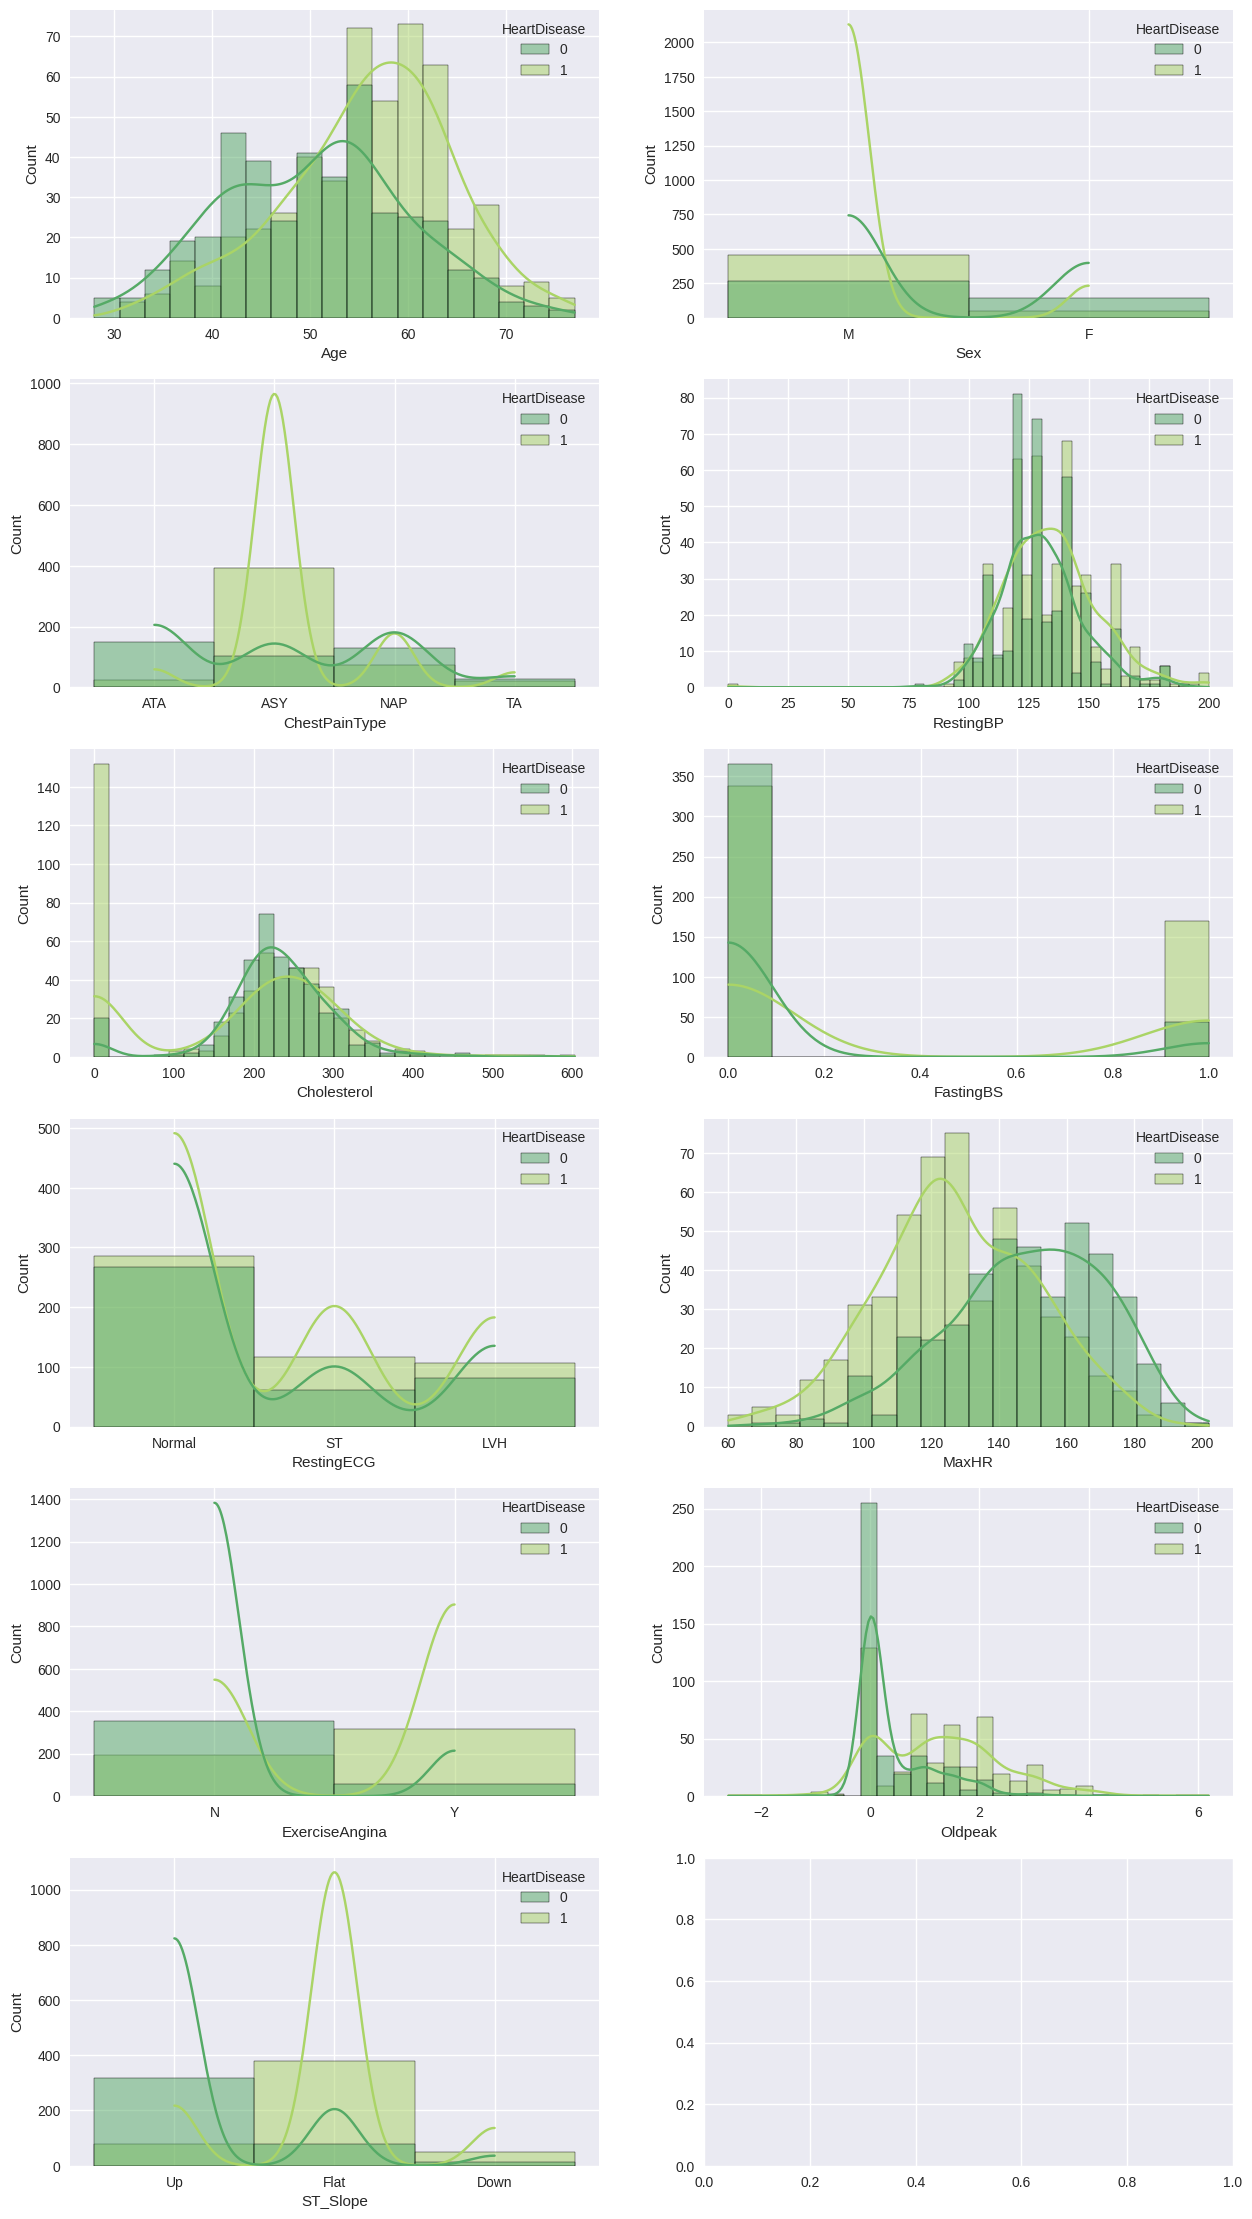

In [9]:
plt.style.use("seaborn")
plt.subplots_adjust(hspace=0.2)
color = 'summer'

fig, axs = plt.subplots(6, 2, figsize=(15,28))
i=1
for feature in df.columns:
    if feature not in ["HeartDisease"] and i < 14:
        plt.subplot(6,2,i)
        sns.histplot(data=df, x=feature, kde=True, palette=color, hue='HeartDisease')
        i+=1

In [10]:
def detect_outliers(label=None):
    Q1 = df[label].quantile(0.25)
    Q3 = df[label].quantile(0.75)
    IQR = Q3 - Q1
    interval = ((df[label] > Q1 - 1.5*IQR) & (df[label] < Q3 + 1.5*IQR))
    return df[interval], df[~interval]

In [11]:
def assign_mean(df_out, not_df_out, label=None):
    df.loc[df_out[df_out["HeartDisease"] == 0].index, label] = not_df_out[not_df_out["HeartDisease"] == 0][label].mean()
    df.loc[df_out[df_out["HeartDisease"] == 1].index, label] = not_df_out[not_df_out["HeartDisease"] == 1][label].mean()
    return

In [12]:
def delete_outliers(df_out):
    return df.drop(df_out.index)

<Axes: xlabel='Cholesterol'>

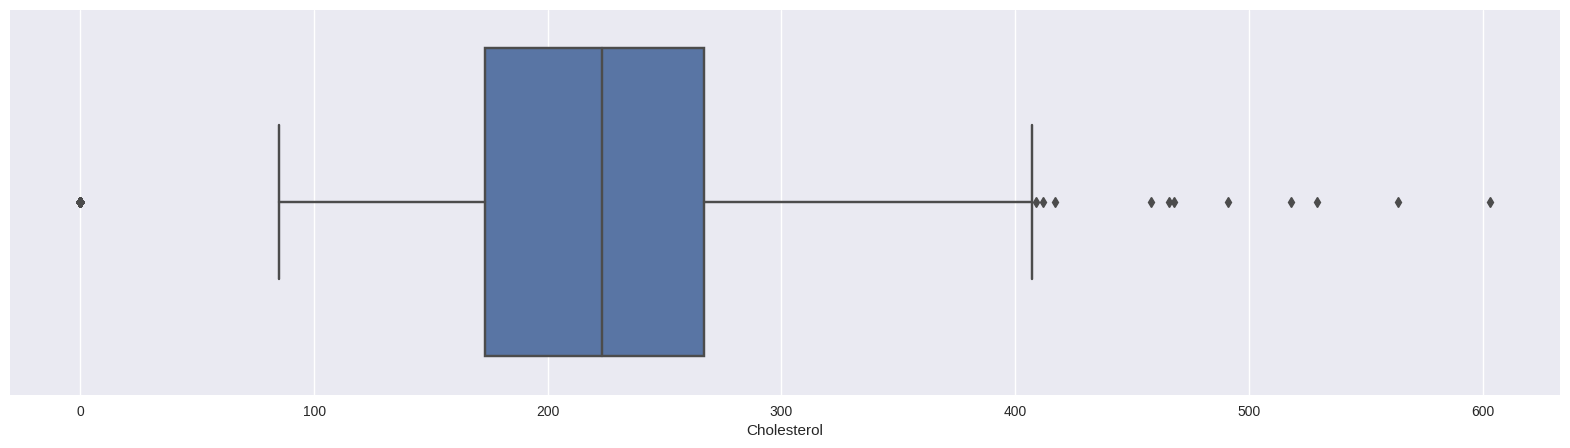

In [13]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df, x="Cholesterol")

In [14]:
not_df_out_ch, df_out_ch = detect_outliers('Cholesterol')
print(f'Outliers in cholesterol represent the {round((df_out_ch.shape[0]*100)/df.shape[0], 2)}% of our dataset')
df_out_ch

Outliers in cholesterol represent the 19.93% of our dataset


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
24,53,F,ATA,113,468,0,Normal,127,N,0.0,Up,0
26,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1
59,44,M,ASY,150,412,0,Normal,170,N,0.0,Up,0
64,32,M,ASY,118,529,0,Normal,130,N,0.0,Flat,1
201,44,M,ASY,135,491,0,Normal,135,N,0.0,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
883,38,M,NAP,100,0,0,Normal,179,N,-1.1,Up,0
889,52,M,ASY,130,0,1,Normal,120,N,0.0,Flat,1
898,60,M,ASY,160,0,0,ST,99,Y,0.5,Flat,1
901,58,M,ASY,116,0,0,Normal,124,N,1.0,Up,1


<Axes: xlabel='Cholesterol', ylabel='Count'>

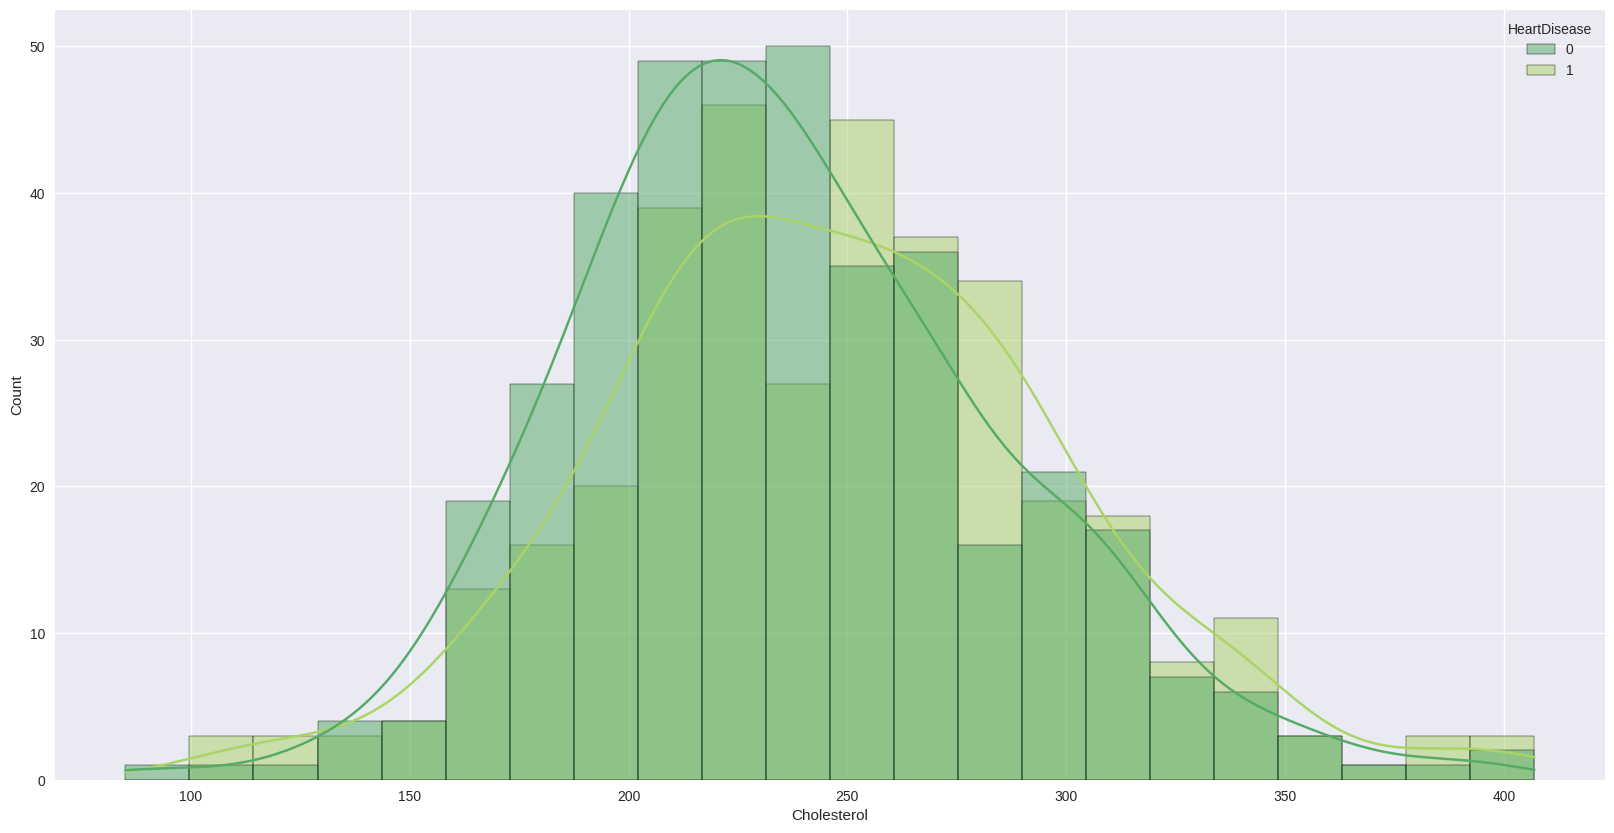

In [15]:
df = delete_outliers(df_out_ch[df_out_ch["Cholesterol"] == 0])
assign_mean(df_out_ch[df_out_ch["Cholesterol"] != 0], not_df_out_ch, 'Cholesterol')

plt.figure(figsize=(20,10))
sns.histplot(data=df, x='Cholesterol', kde=True, palette=color, hue='HeartDisease')

<Axes: xlabel='RestingBP'>

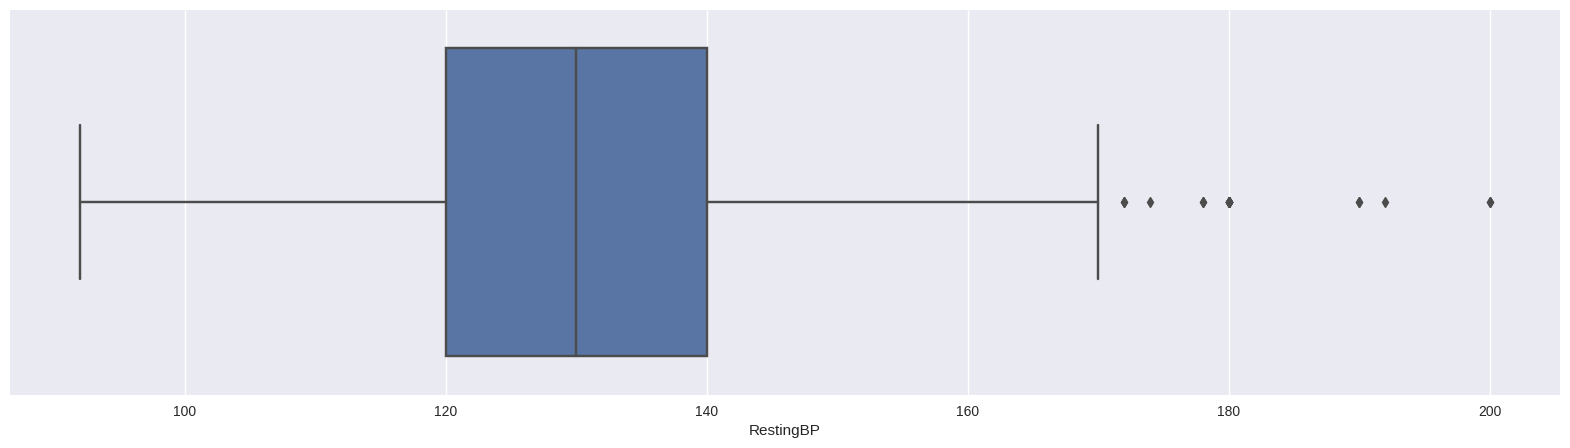

In [16]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df, x="RestingBP")

In [17]:
not_df_out_rbp, df_out_rbp = detect_outliers('RestingBP')
print(f'Outliers in resting blood pressure represent the {round((df_out_rbp.shape[0]*100)/df.shape[0], 2)}% of our dataset')
df_out_rbp

Outliers in resting blood pressure represent the 4.29% of our dataset


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
72,65,M,ASY,170,263.0,1,Normal,112,Y,2.0,Flat,1
89,39,M,ATA,190,241.0,0,Normal,106,N,0.0,Up,0
100,58,F,ATA,180,393.0,0,Normal,110,Y,1.0,Flat,1
108,56,M,ASY,170,388.0,0,ST,122,Y,2.0,Flat,1
156,53,M,ASY,180,285.0,0,ST,120,Y,1.5,Flat,1
157,46,M,ASY,180,280.0,0,ST,120,N,0.0,Up,0
176,30,F,TA,170,237.0,0,ST,170,N,0.0,Up,0
222,45,F,ATA,180,295.0,0,Normal,180,N,0.0,Up,0
223,59,M,NAP,180,213.0,0,Normal,100,N,0.0,Up,0
225,57,F,ASY,180,347.0,0,ST,126,Y,0.8,Flat,0


<Axes: xlabel='RestingBP', ylabel='Count'>

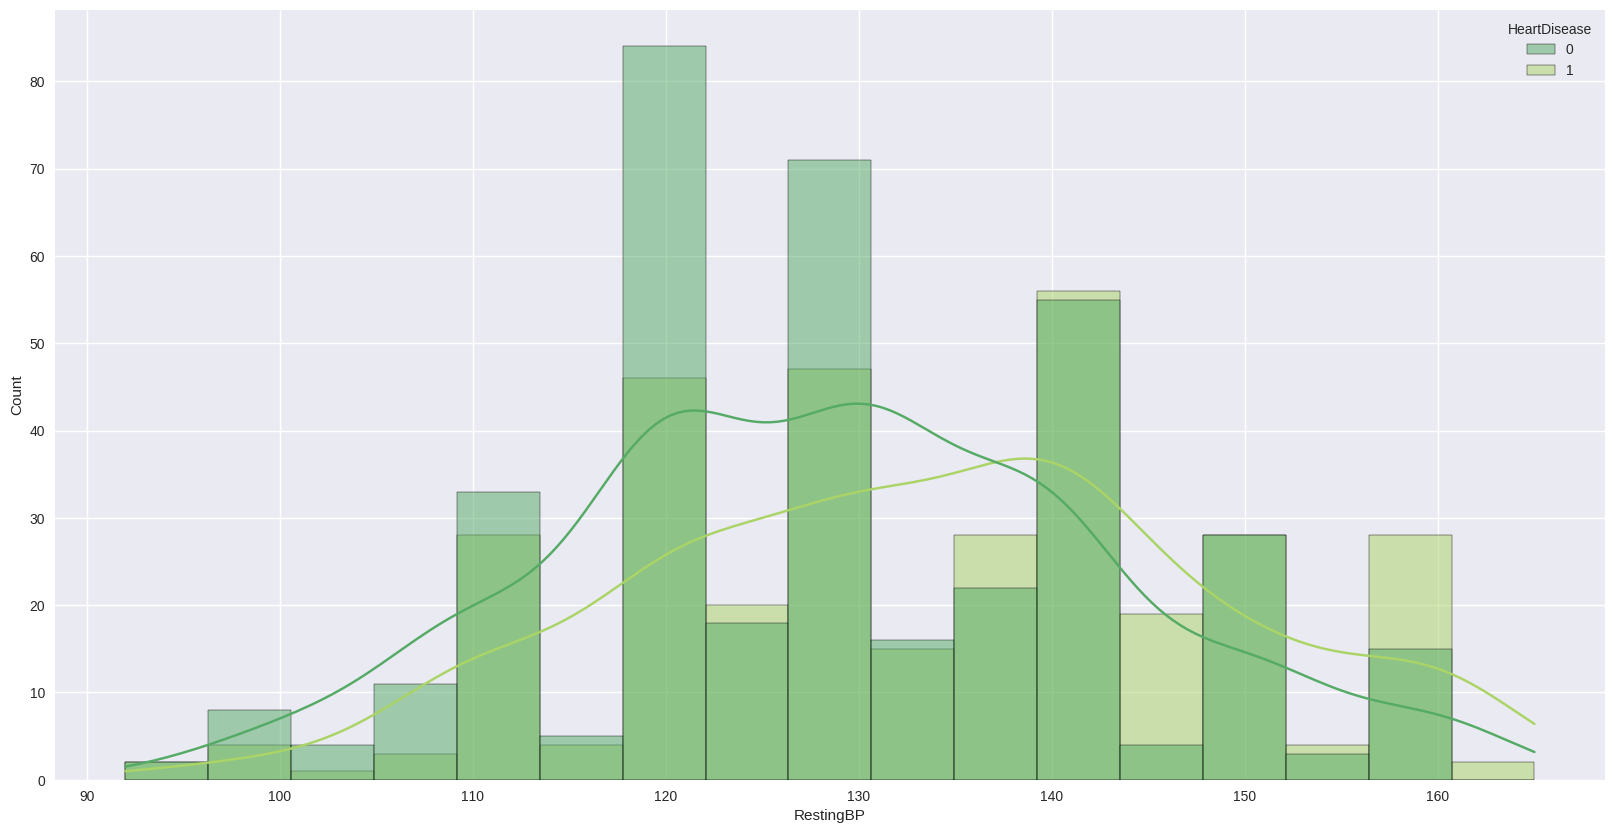

In [18]:
df = delete_outliers(df_out_rbp)
plt.figure(figsize=(20,10))
sns.histplot(data=df, x='RestingBP', kde=True, palette=color, hue='HeartDisease')

In [19]:
col = list(df.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(df[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


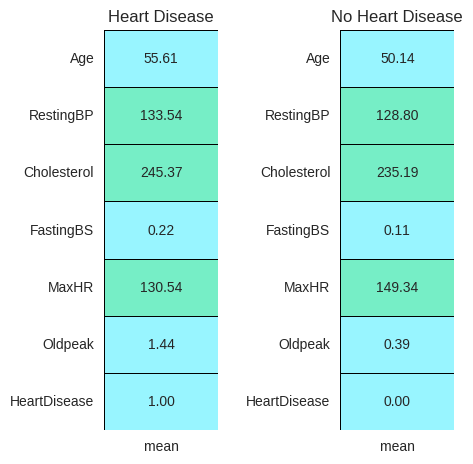

In [20]:
colors = ['#98F5FF','#76EEC6']
yes = df[df['HeartDisease'] == 1].describe().T
no = df[df['HeartDisease'] == 0].describe().T

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(yes[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f',)
plt.title('Heart Disease');

plt.subplot(1,2,2)
sns.heatmap(no[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('No Heart Disease');

fig.tight_layout(pad = 2)

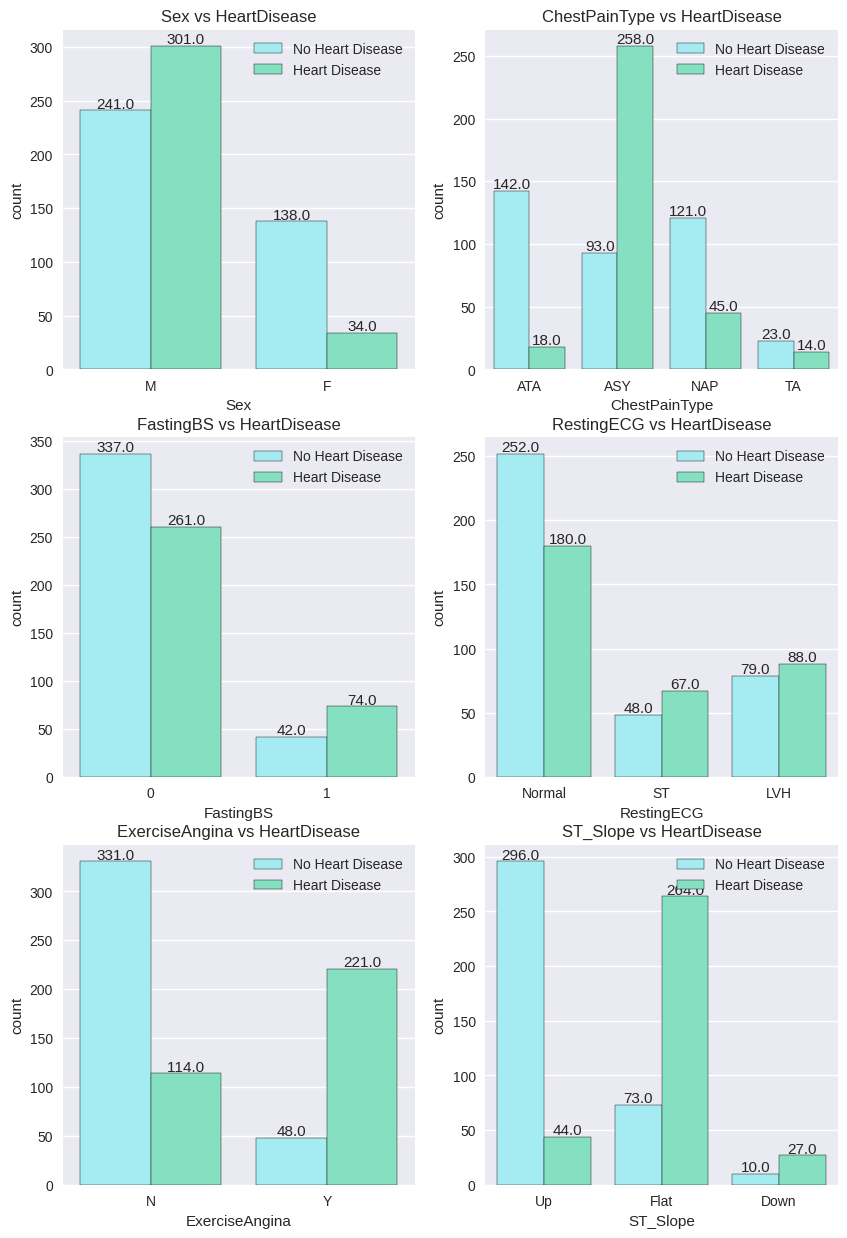

In [21]:
fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (10,15))
for i in range(len(categorical_features) - 1):
    plt.subplot(3,2,i+1)
    ax = sns.countplot(data = df,x=categorical_features[i],hue = "HeartDisease",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = categorical_features[i] + ' vs HeartDisease'
    plt.legend(['No Heart Disease','Heart Disease'])
    plt.title(title);

In [22]:
sex = df[df['HeartDisease'] == 1]['Sex'].value_counts()
sex = [sex[0] / sum(sex) * 100, sex[1] / sum(sex) * 100]

cp = df[df['HeartDisease'] == 1]['ChestPainType'].value_counts()
cp = [cp[0] / sum(cp) * 100,cp[1] / sum(cp) * 100,cp[2] / sum(cp) * 100,cp[3] / sum(cp) * 100]

fbs = df[df['HeartDisease'] == 1]['FastingBS'].value_counts()
fbs = [fbs[0] / sum(fbs) * 100,fbs[1] / sum(fbs) * 100]

restecg = df[df['HeartDisease'] == 1]['RestingECG'].value_counts()
restecg = [restecg[0] / sum(restecg) * 100,restecg[1] / sum(restecg) * 100,restecg[2] / sum(restecg) * 100]

exang = df[df['HeartDisease'] == 1]['ExerciseAngina'].value_counts()
exang = [exang[0] / sum(exang) * 100,exang[1] / sum(exang) * 100]

slope = df[df['HeartDisease'] == 1]['ST_Slope'].value_counts()
slope = [slope[0] / sum(slope) * 100,slope[1] / sum(slope) * 100,slope[2] / sum(slope) * 100]

<ipython-input-23-ca68310860e1>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,1)
<ipython-input-23-ca68310860e1>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,2)
<ipython-input-23-ca68310860e1>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,3)
<ipython-input-23-ca68310860e1>:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,4)
<ipython-input-23-ca68310860e1>:23: MatplotlibDeprecationWarning: Auto-removal of over

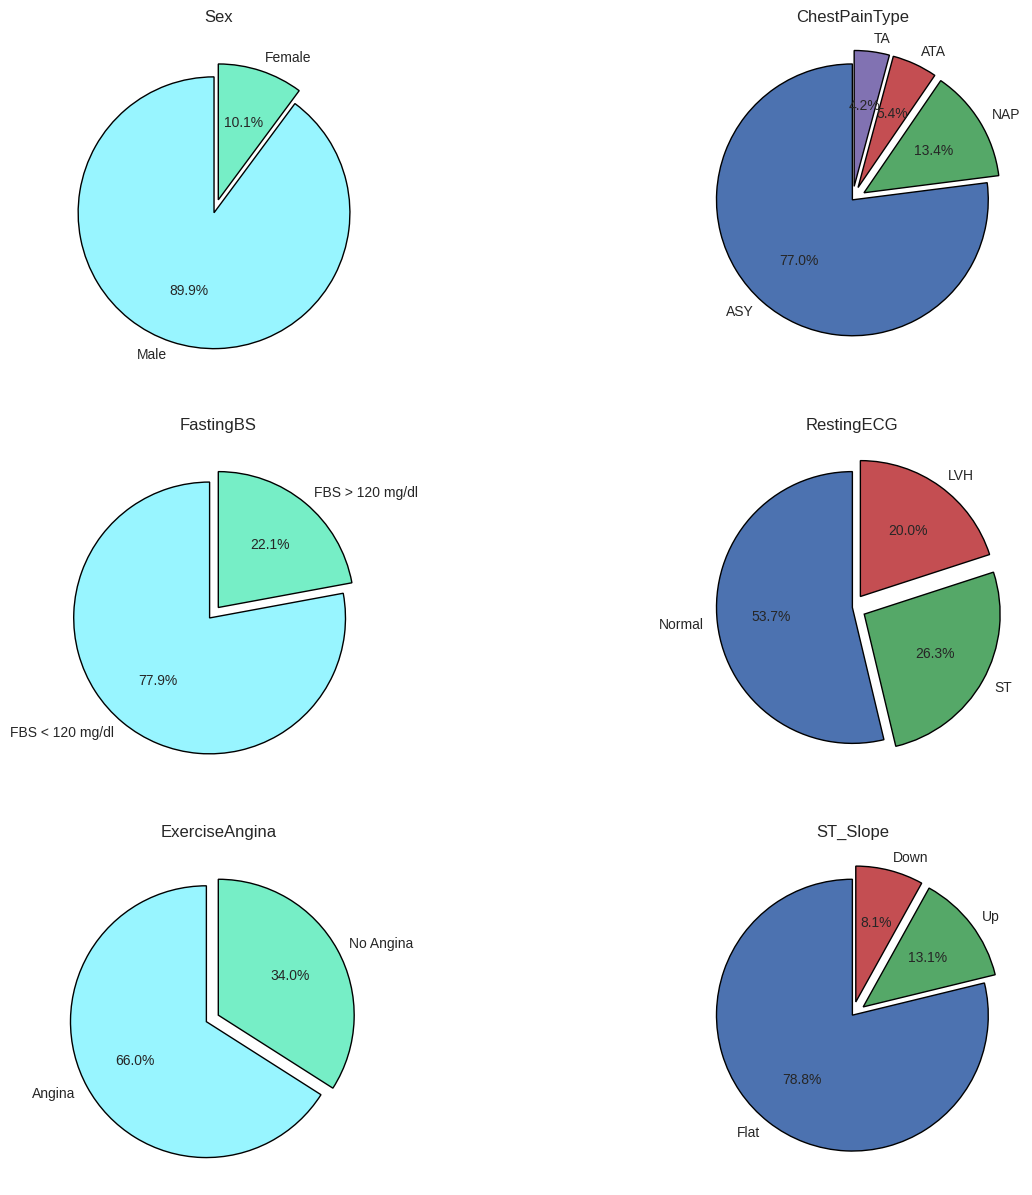

In [23]:
ax,fig = plt.subplots(nrows = 4,ncols = 2,figsize = (15,15))

plt.subplot(3,2,1)
plt.pie(sex,labels = ['Male','Female'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Sex');

plt.subplot(3,2,2)
plt.pie(cp,labels = ['ASY', 'NAP', 'ATA', 'TA'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1,0.1,0.1),
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('ChestPainType');

plt.subplot(3,2,3)
plt.pie(fbs,labels = ['FBS < 120 mg/dl','FBS > 120 mg/dl'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('FastingBS');

plt.subplot(3,2,4)
plt.pie(restecg,labels = ['Normal','ST','LVH'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1,0.1),
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('RestingECG');

plt.subplot(3,2,5)
plt.pie(exang,labels = ['Angina','No Angina'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('ExerciseAngina');

plt.subplot(3,2,6)
plt.pie(slope,labels = ['Flat','Up','Down'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1,0.1),
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('ST_Slope');

In [24]:
df['RestingBP_Group'] = [ int(i / 5) for i in df['RestingBP']]
df['Cholesterol_Group'] = [ int(i / 10) for i in df['Cholesterol']]
df['MaxHR_Group'] = [ int(i / 5) for i in df['MaxHR']]
df['Oldpeak_Group'] = [ int( (i*10) / 5) for i in df['Oldpeak']]

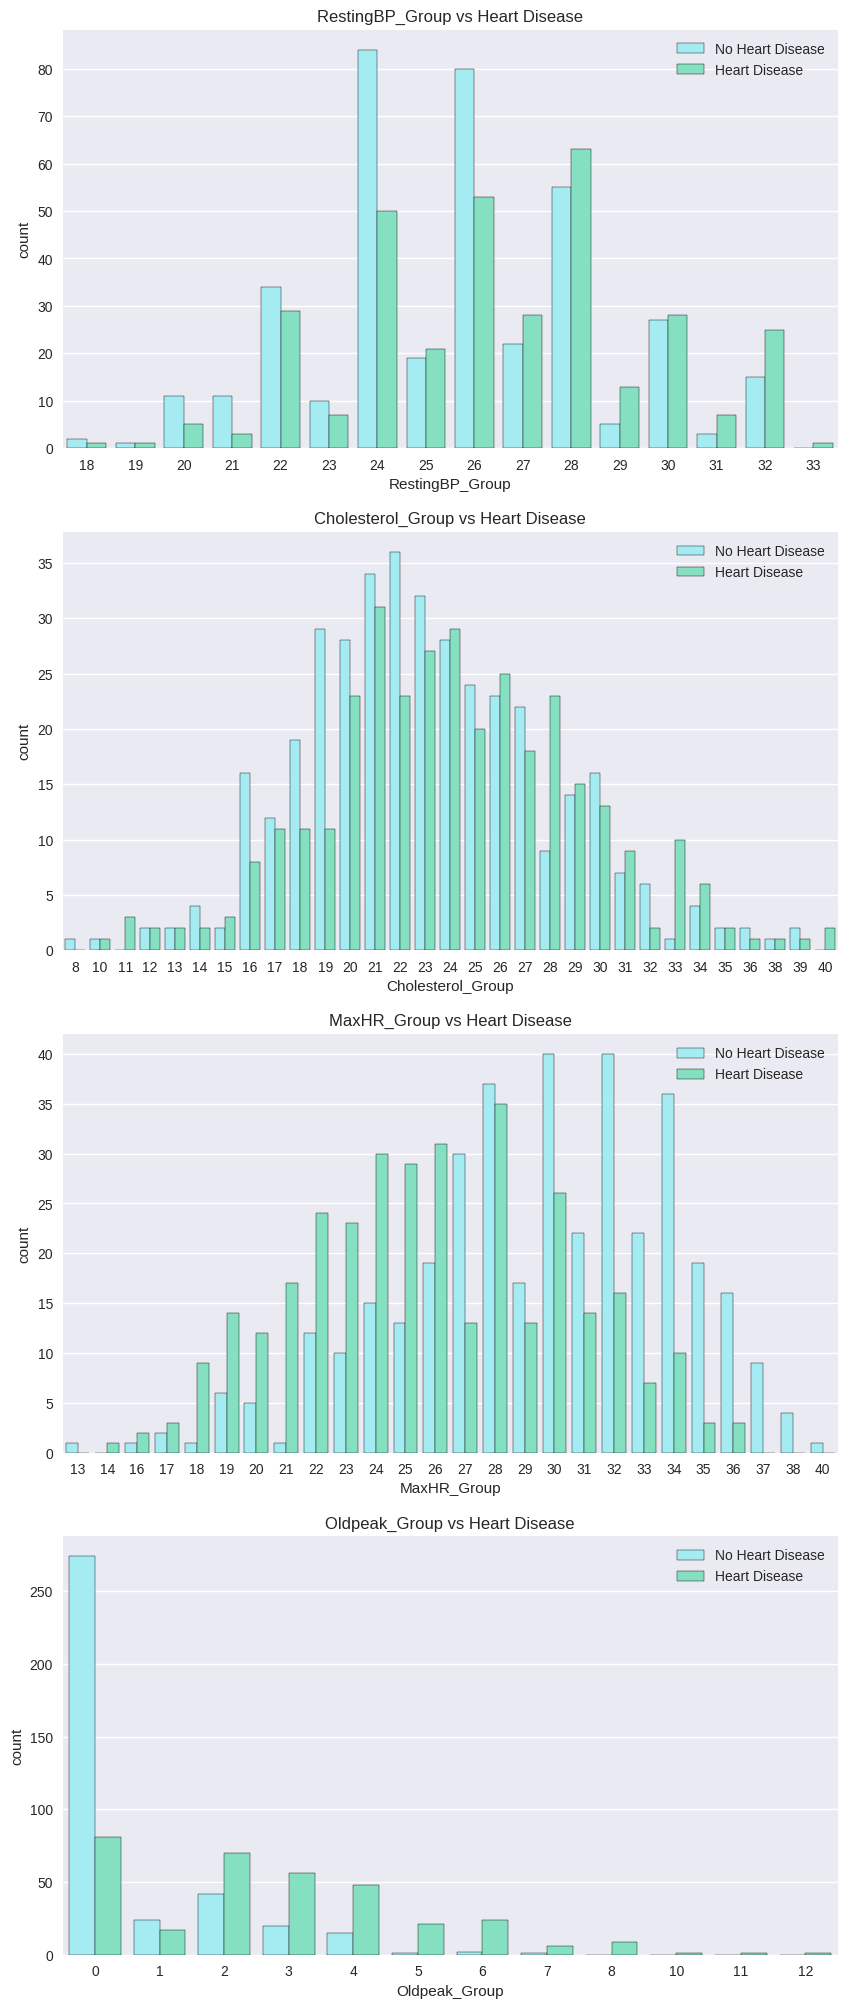

In [25]:
fig, ax = plt.subplots(nrows = 4,ncols = 1,figsize = (10,25))
group_numerical_features = [i + '_Group' for i in numerical_features[1:]]
for i in range(len(group_numerical_features)):
    plt.subplot(4,1,i+1)
    sns.countplot(data = df, x=group_numerical_features[i],hue = "HeartDisease",palette = colors, edgecolor = 'black')
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = group_numerical_features[i] + ' vs Heart Disease'
    plt.title(title);

In [26]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization
df1 = df.copy(deep = True)
df1['Oldpeak'] = mms.fit_transform(df1[['Oldpeak']])
df1['Age'] = ss.fit_transform(df1[['Age']])
df1['RestingBP'] = ss.fit_transform(df1[['RestingBP']])
df1['Cholesterol'] = ss.fit_transform(df1[['Cholesterol']])
df1['MaxHR'] = ss.fit_transform(df1[['MaxHR']])
df1.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_Group,Cholesterol_Group,MaxHR_Group,Oldpeak_Group
0,-1.337734,M,ATA,0.612417,0.973918,0,Normal,1.291921,N,0.015873,Up,0,28,28,34,0
1,-1.653588,M,ATA,-0.069638,0.854739,0,ST,-1.744958,N,0.015873,Up,0,26,28,19,0
2,-0.495457,F,ASY,0.476006,-0.515824,0,Normal,-1.334569,Y,0.253968,Flat,1,27,21,21,3
3,0.136251,M,NAP,1.294472,-0.893226,0,Normal,-0.760024,N,0.015873,Up,0,30,19,24,0
4,-1.443019,M,NAP,-0.751693,1.967080,0,Normal,1.209843,N,0.015873,Up,0,24,33,34,0


<ipython-input-27-fa001402b3e2>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df1.corr(),cmap = colors,annot = True);


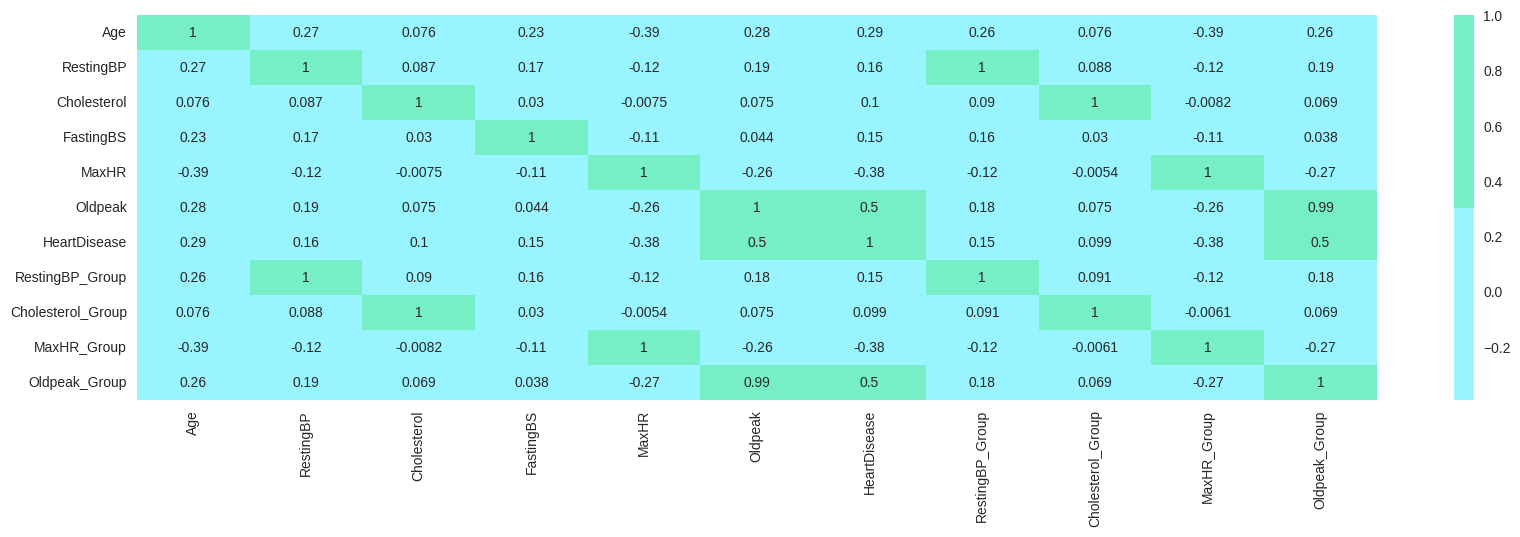

In [27]:
plt.figure(figsize = (20,5))
sns.heatmap(df1.corr(),cmap = colors,annot = True);

<ipython-input-28-c19422ea8e03>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df1.corrwith(df1['HeartDisease']).sort_values(ascending = False).to_frame()


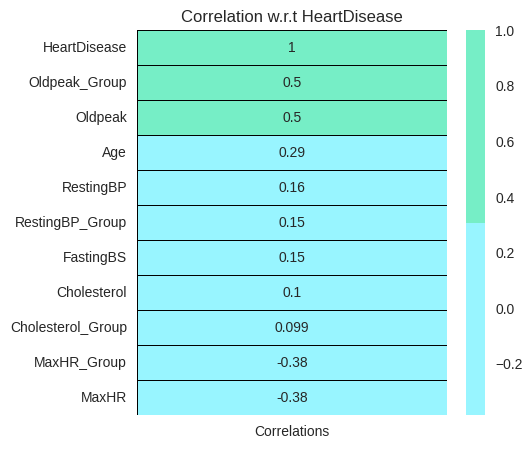

In [28]:
corr = df1.corrwith(df1['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t HeartDisease');

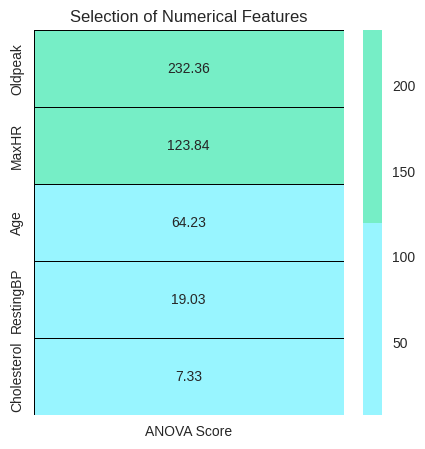

In [29]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

features = df1.loc[:,numerical_features]
target = df1.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score'])

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

In [30]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


# Separate the features and labels
X = df.drop('HeartDisease', axis=1)
X = X[categorical]
y = df['HeartDisease']

# Perform one-hot encoding on categorical features
X = pd.get_dummies(X)

selector = SelectKBest(chi2)
selector.fit(X, y)

# Perform feature selection using chi-squared test
scores = selector.scores_
feature_names = X.columns

# Print the scores and names of each feature
for i in range(len(feature_names)):
    print('Feature %s: %.3f' % (feature_names[i], scores[i]))

Feature ChestPainType_ASY: 99.611
Feature ChestPainType_ATA: 81.735
Feature ChestPainType_NAP: 26.158
Feature ChestPainType_TA: 1.225
Feature RestingECG_LVH: 2.237
Feature RestingECG_Normal: 4.785
Feature RestingECG_ST: 5.940
Feature ST_Slope_Down: 10.085
Feature ST_Slope_Flat: 133.580
Feature ST_Slope_Up: 157.607


In [31]:
features = df1.loc[:,categorical_features[:-1]]
features = pd.get_dummies(features)
target = df1.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score'])
print(featureScores)

                   Chi Squared Score
FastingBS                  13.262451
Sex_F                      50.912325
Sex_M                      16.156679
ChestPainType_ASY          99.611478
ChestPainType_ATA          81.735099
ChestPainType_NAP          26.157973
ChestPainType_TA            1.225109
RestingECG_LVH              2.236968
RestingECG_Normal           4.784783
RestingECG_ST               5.940149
ExerciseAngina_N           81.070684
ExerciseAngina_Y          134.113214
ST_Slope_Down              10.084858
ST_Slope_Flat             133.579915
ST_Slope_Up               157.607360


In [32]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import LabelEncoder

In [33]:

df1 = df_1.copy(deep = True)

mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df1['Oldpeak'] = mms.fit_transform(df1[['Oldpeak']])
df1['Age'] = ss.fit_transform(df1[['Age']])
df1['RestingBP'] = ss.fit_transform(df1[['RestingBP']])
df1['Cholesterol'] = ss.fit_transform(df1[['Cholesterol']])
df1['MaxHR'] = ss.fit_transform(df1[['MaxHR']])

In [34]:
df2 = df_2.copy(deep = True)

mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df2['Oldpeak'] = mms.fit_transform(df2[['Oldpeak']])
df2['Age'] = ss.fit_transform(df2[['Age']])
df2['RestingBP'] = ss.fit_transform(df2[['RestingBP']])
df2['Cholesterol'] = ss.fit_transform(df2[['Cholesterol']])
df2['MaxHR'] = ss.fit_transform(df2[['MaxHR']])

In [35]:
x_train = df1[df1.columns.drop(['HeartDisease'])]
cat_cols = df1.select_dtypes(include='object').columns
x_train = pd.get_dummies(x_train, columns=cat_cols)
y_train = df1['HeartDisease']
x_test = df2[df2.columns.drop(['HeartDisease'])]
x_test = pd.get_dummies(x_test, columns=cat_cols)
y_test = df2['HeartDisease']
y_train = y_train.astype(int)
y_test = y_test.astype(int)

Following [*Interpretable Neural Networks With PyTorch*](https://towardsdatascience.com/interpretable-neural-networks-with-pytorch-76f1c31260fe)

In [36]:
import torch
import math

torch.manual_seed(9421) # keep things reproducible

Implementation of the Block Linear Layer

In [37]:
class BlockLinear(torch.nn.Module):
    def __init__(self, n_blocks, in_features, out_features):
        super().__init__()
        self.n_blocks = n_blocks
        self.in_features = in_features
        self.out_features = out_features
        self.block_weights = []
        self.block_biases = []
        for i in range(n_blocks):
            block_weight = torch.Tensor(out_features, in_features)
            block_weight = torch.nn.Parameter(block_weight)
            torch.nn.init.kaiming_uniform_(block_weight)
            self.register_parameter(
                f'block_weight_{i}',
                block_weight
            )
            self.block_weights.append(block_weight)
            block_bias = torch.Tensor(out_features)
            block_bias = torch.nn.Parameter(block_bias)
            bound = 1 / math.sqrt(in_features)
            torch.nn.init.uniform_(block_bias, -bound, bound)
            self.register_parameter(
                f'block_bias_{i}',
                block_bias
            )
            self.block_biases.append(block_bias)

    def forward(self, x):
        block_size = x.size(1) // self.n_blocks
        x_blocks = torch.split(
            x,
            split_size_or_sections=block_size,
            dim=1
        )
        block_outputs = []
        for block_id in range(self.n_blocks):
            block_outputs.append(
                x_blocks[block_id] @ self.block_weights[block_id].t() + self.block_biases[block_id]
            )
        return torch.cat(block_outputs, dim=1)

Defining the model

In [38]:
class Model(torch.nn.Module):
    def __init__(self, dropout):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            BlockLinear(20, 1, 8),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            BlockLinear(20, 8, 8),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            BlockLinear(20, 8, 8),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            BlockLinear(20, 8, 1),
        )
        
        self.lr = torch.nn.Linear(20, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.features(x)
        x = self.lr(x)
        x = self.sigmoid(x)
        return x

dropout = 0.2
model = Model(dropout)

Converting data streams in Tensors as inputs to the PyTorch models

In [39]:
x_tr = torch.tensor(x_train.values, dtype=torch.float)
y_tr = torch.tensor(y_train.values, dtype=torch.float)
y_tr = y_tr.reshape(-1, 1)

In [40]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss()

model.train()

for i in range(2000):
    optimizer.zero_grad()
    y_pred = model(x_tr)
    loss = criterion(y_pred, y_tr)
    loss.backward()
    optimizer.step()
    if (i) % 100 == 0:
      acc = (y_pred.reshape(-1).detach().numpy().round() == y_tr.reshape(-1).detach().numpy().round()).mean()
      print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

epoch 0	loss : 0.7067791223526001	 accuracy : 0.5940054495912807
epoch 100	loss : 0.46504515409469604	 accuracy : 0.7942779291553134
epoch 200	loss : 0.35286569595336914	 accuracy : 0.8528610354223434
epoch 300	loss : 0.3484106957912445	 accuracy : 0.8623978201634878
epoch 400	loss : 0.34194517135620117	 accuracy : 0.8637602179836512
epoch 500	loss : 0.33639705181121826	 accuracy : 0.8623978201634878
epoch 600	loss : 0.3097865879535675	 accuracy : 0.8760217983651226
epoch 700	loss : 0.3463643193244934	 accuracy : 0.8678474114441417
epoch 800	loss : 0.32792556285858154	 accuracy : 0.8732970027247956
epoch 900	loss : 0.3165089786052704	 accuracy : 0.8773841961852861
epoch 1000	loss : 0.3389218747615814	 accuracy : 0.8719346049046321
epoch 1100	loss : 0.33330845832824707	 accuracy : 0.8623978201634878
epoch 1200	loss : 0.31662535667419434	 accuracy : 0.8760217983651226
epoch 1300	loss : 0.32930731773376465	 accuracy : 0.8664850136239782
epoch 1400	loss : 0.3256229758262634	 accuracy : 0.8

Testing the model, generatiing predictions

In [41]:
model.eval()

y_pred_test = model(torch.tensor(x_test.values, dtype=torch.float)).detach().numpy()
y_pred_test = np.round(y_pred_test)

Generating Classification Report and Confusion Matrix

              precision    recall  f1-score   support

           0       0.85      0.70      0.77        74
           1       0.82      0.92      0.87       110

    accuracy                           0.83       184
   macro avg       0.84      0.81      0.82       184
weighted avg       0.83      0.83      0.83       184



Text(70.72222222222221, 0.5, 'True Label')

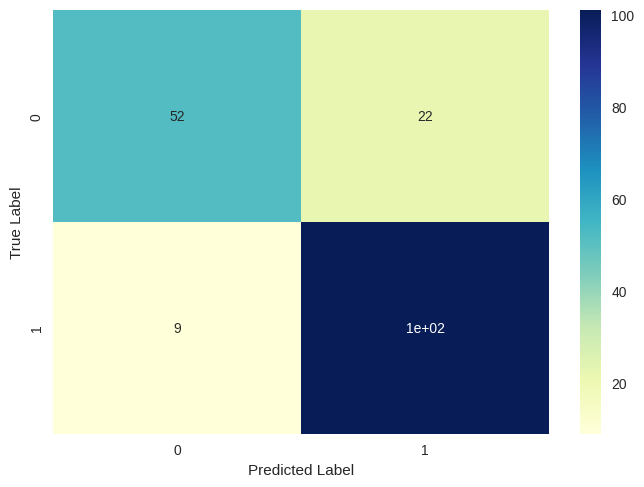

In [49]:
print(classification_report(y_true = y_test, y_pred = y_pred_test))

c_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
colors = ['#98F5FF','#76EEC6']
sns.heatmap(c_mat, annot=True, cmap = "YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("True")

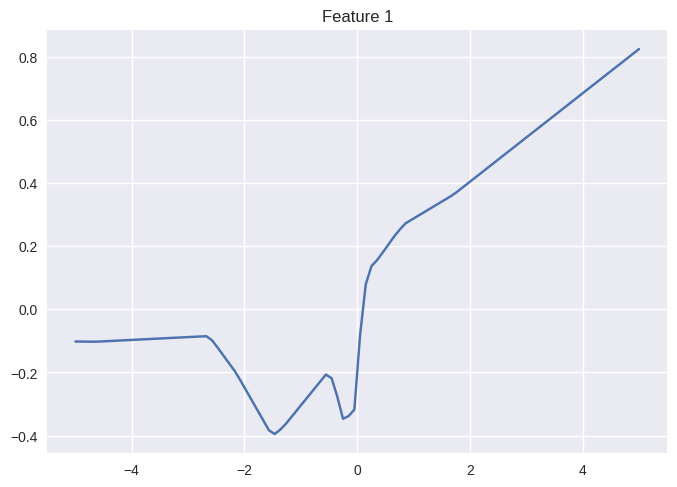

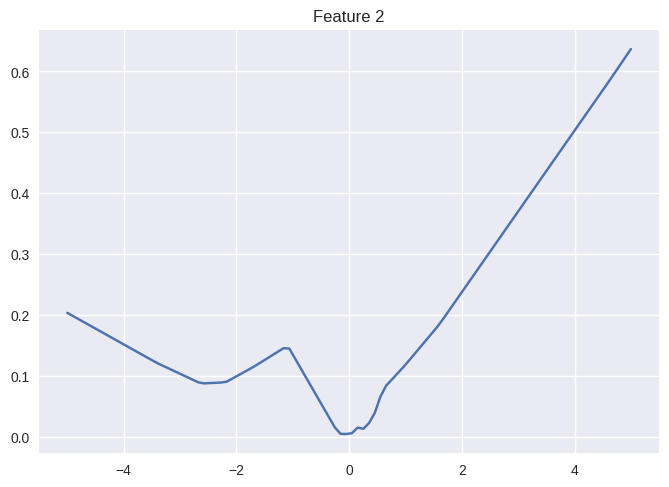

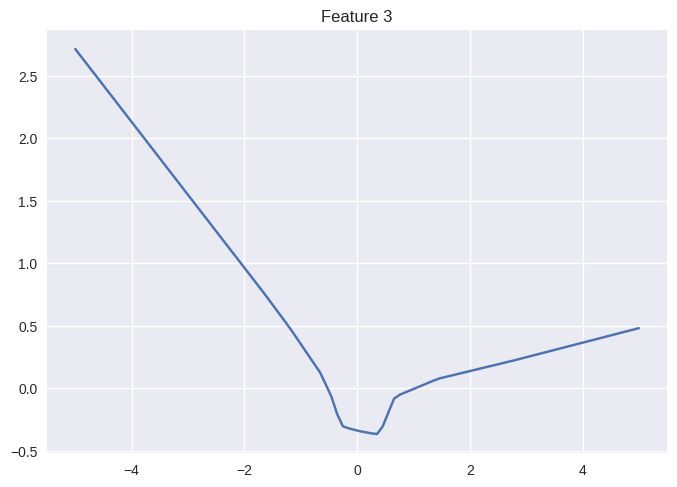

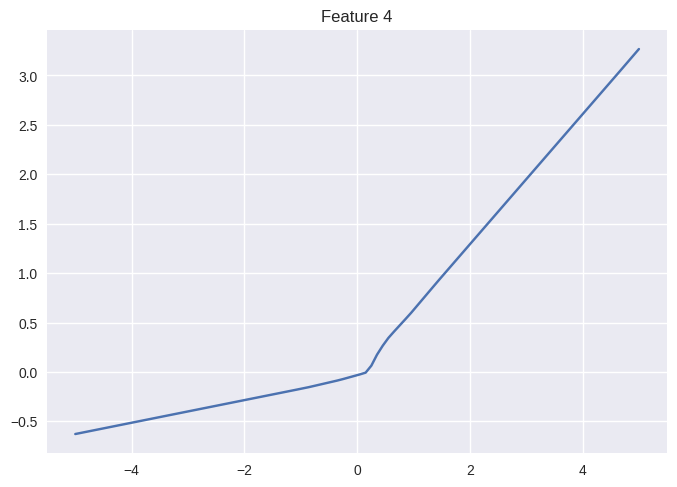

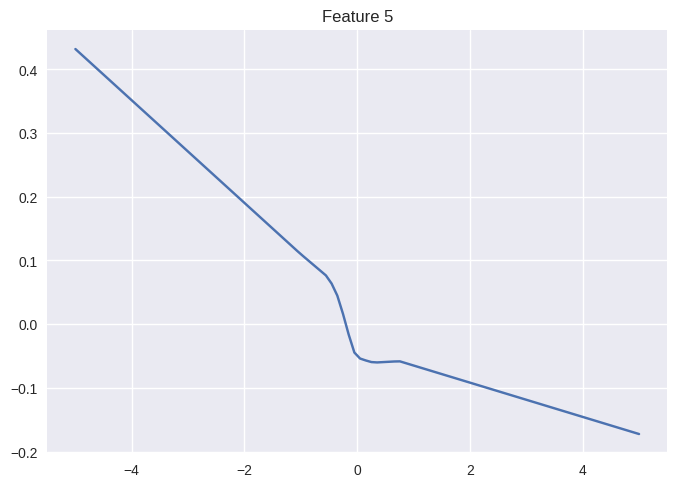

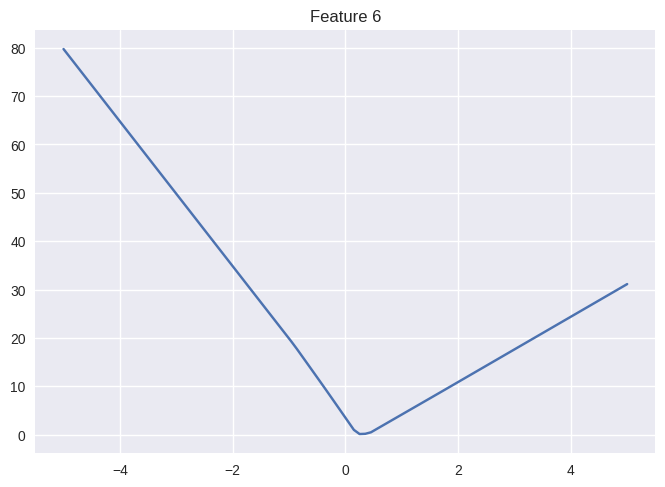

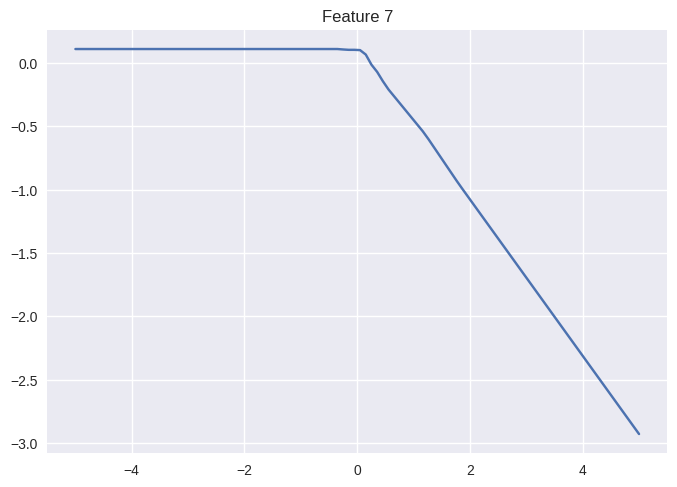

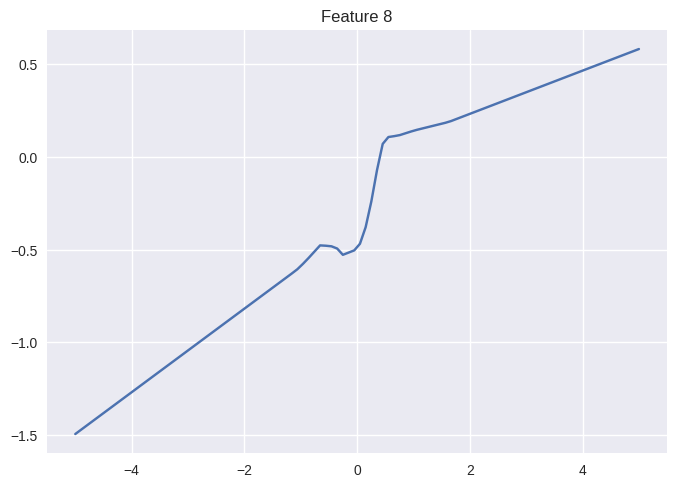

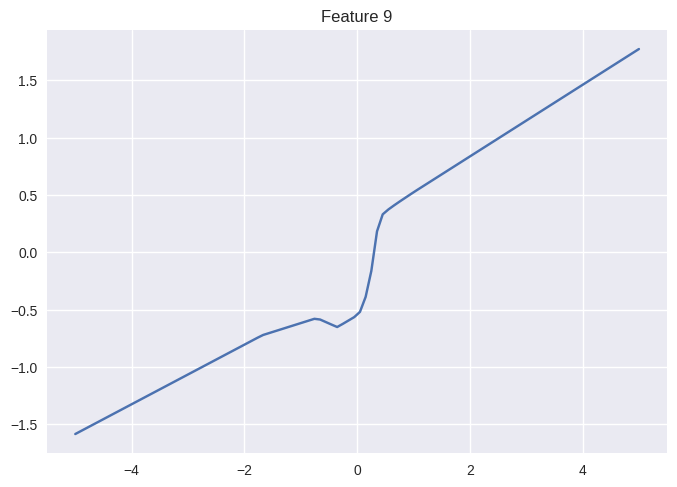

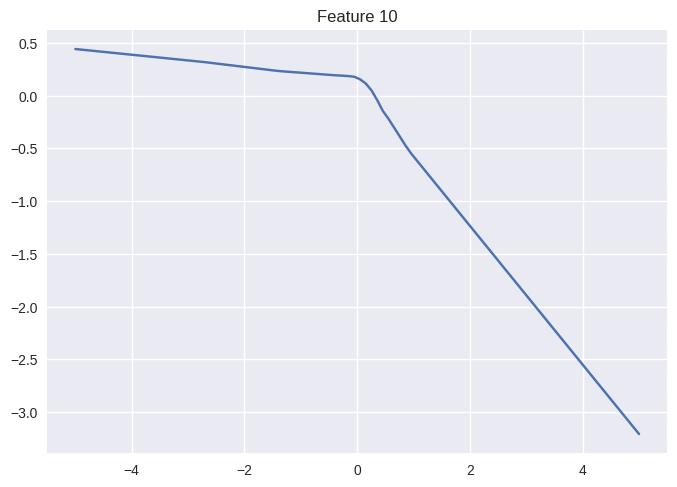

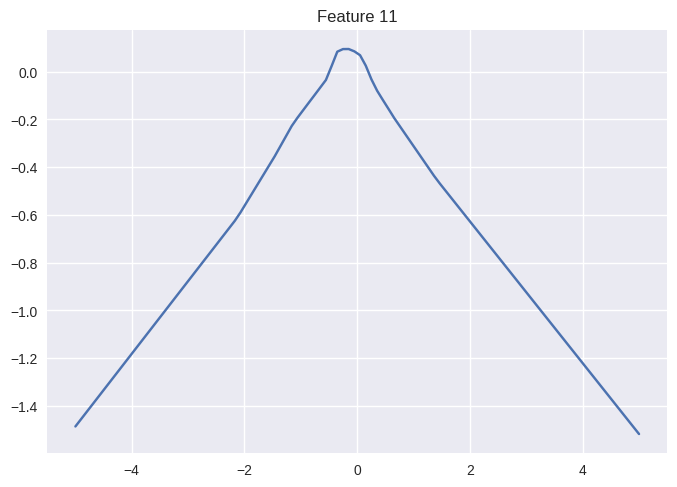

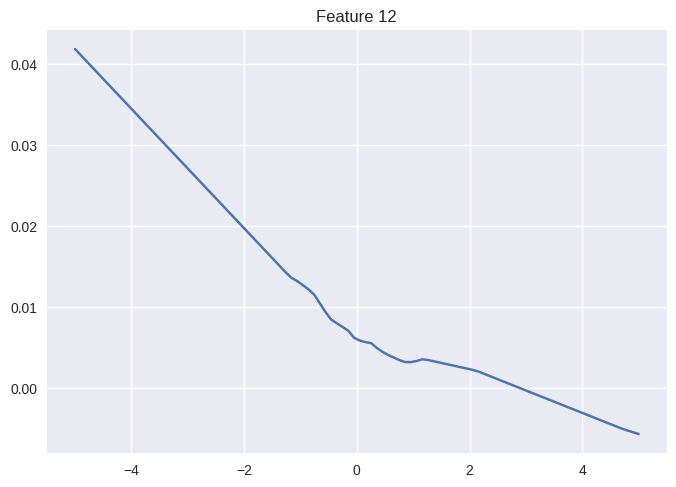

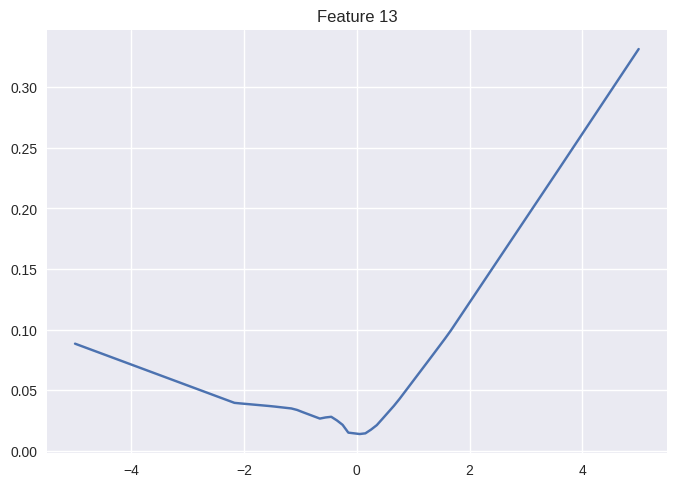

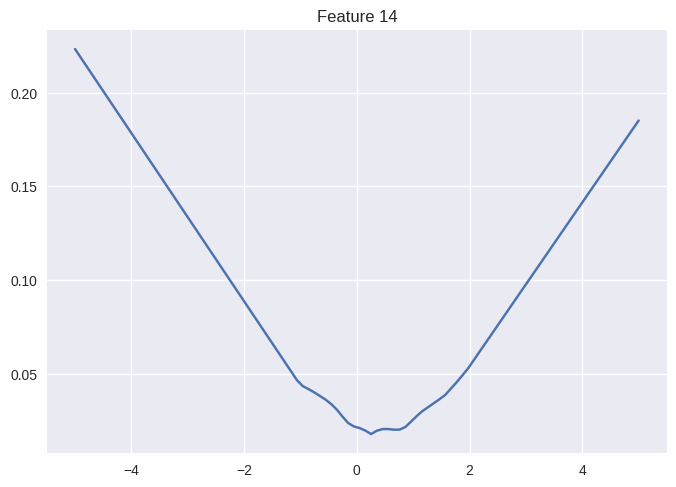

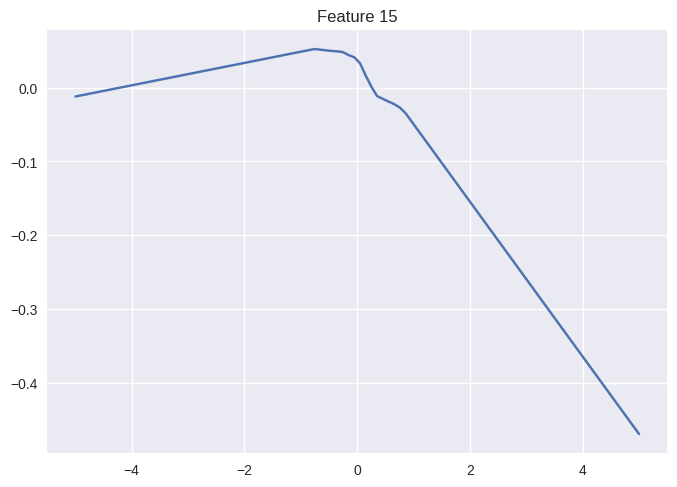

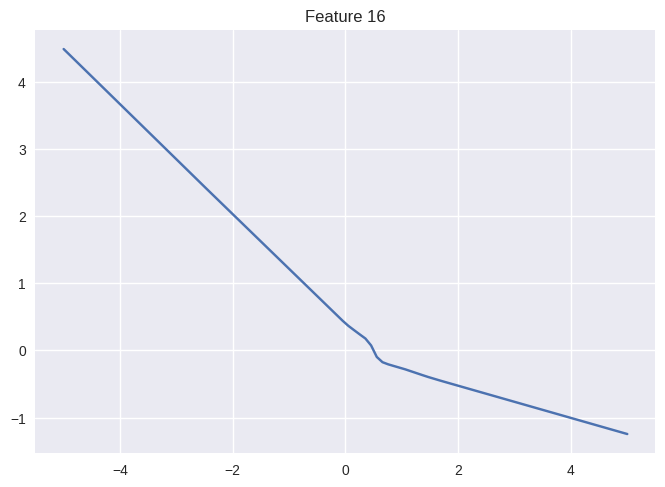

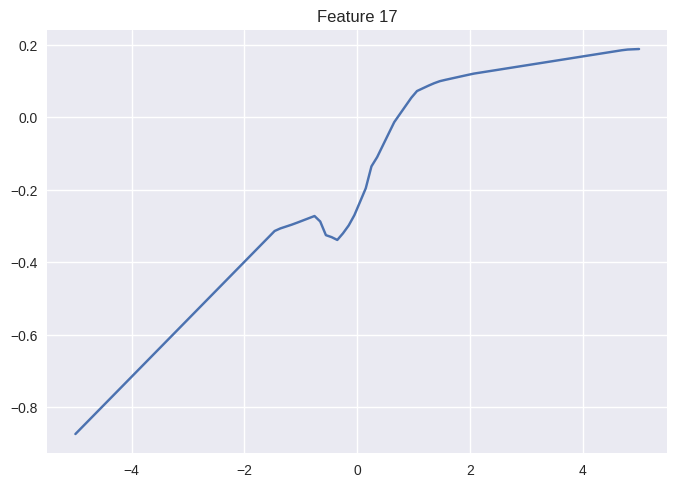

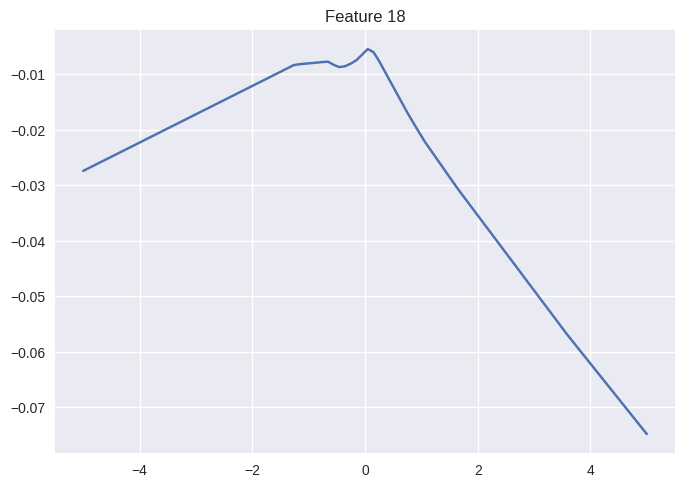

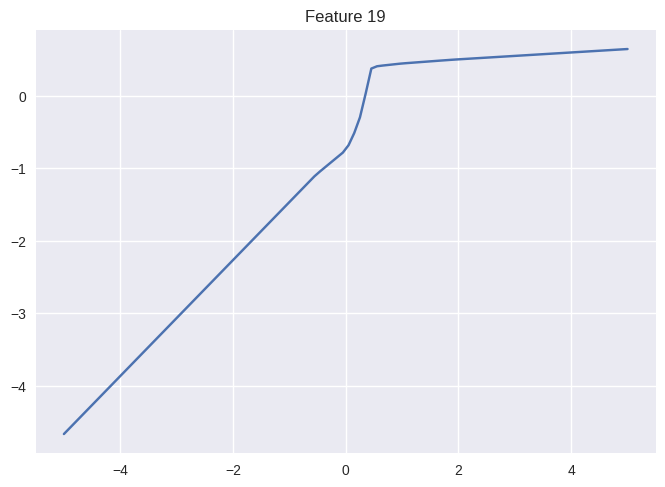

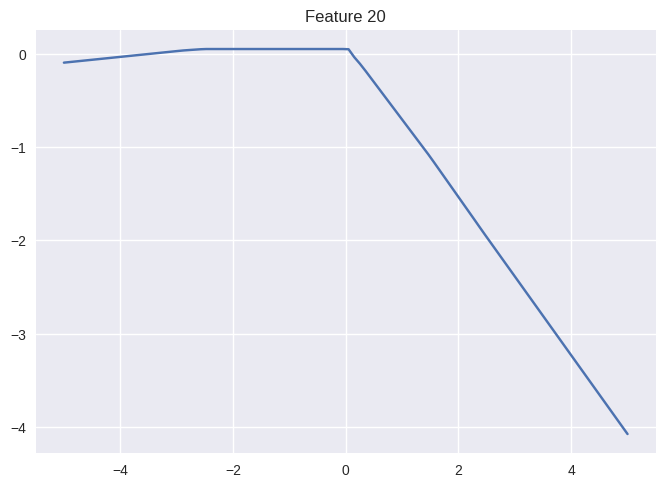

In [50]:
import matplotlib.pyplot as plt

x = torch.linspace(-5, 5, 100).reshape(-1, 1)
x = torch.hstack(20*[x])

for i in range(20):
    plt.plot(
        x[:, 0].detach().numpy(),
        model.get_submodule('lr').weight[0][i].item() * model.get_submodule('features')(x)[:, i].detach().numpy())
    plt.title(f'Feature {i+1}')
    plt.show()

In [51]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 10.2 MB/s eta 0:00:00


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


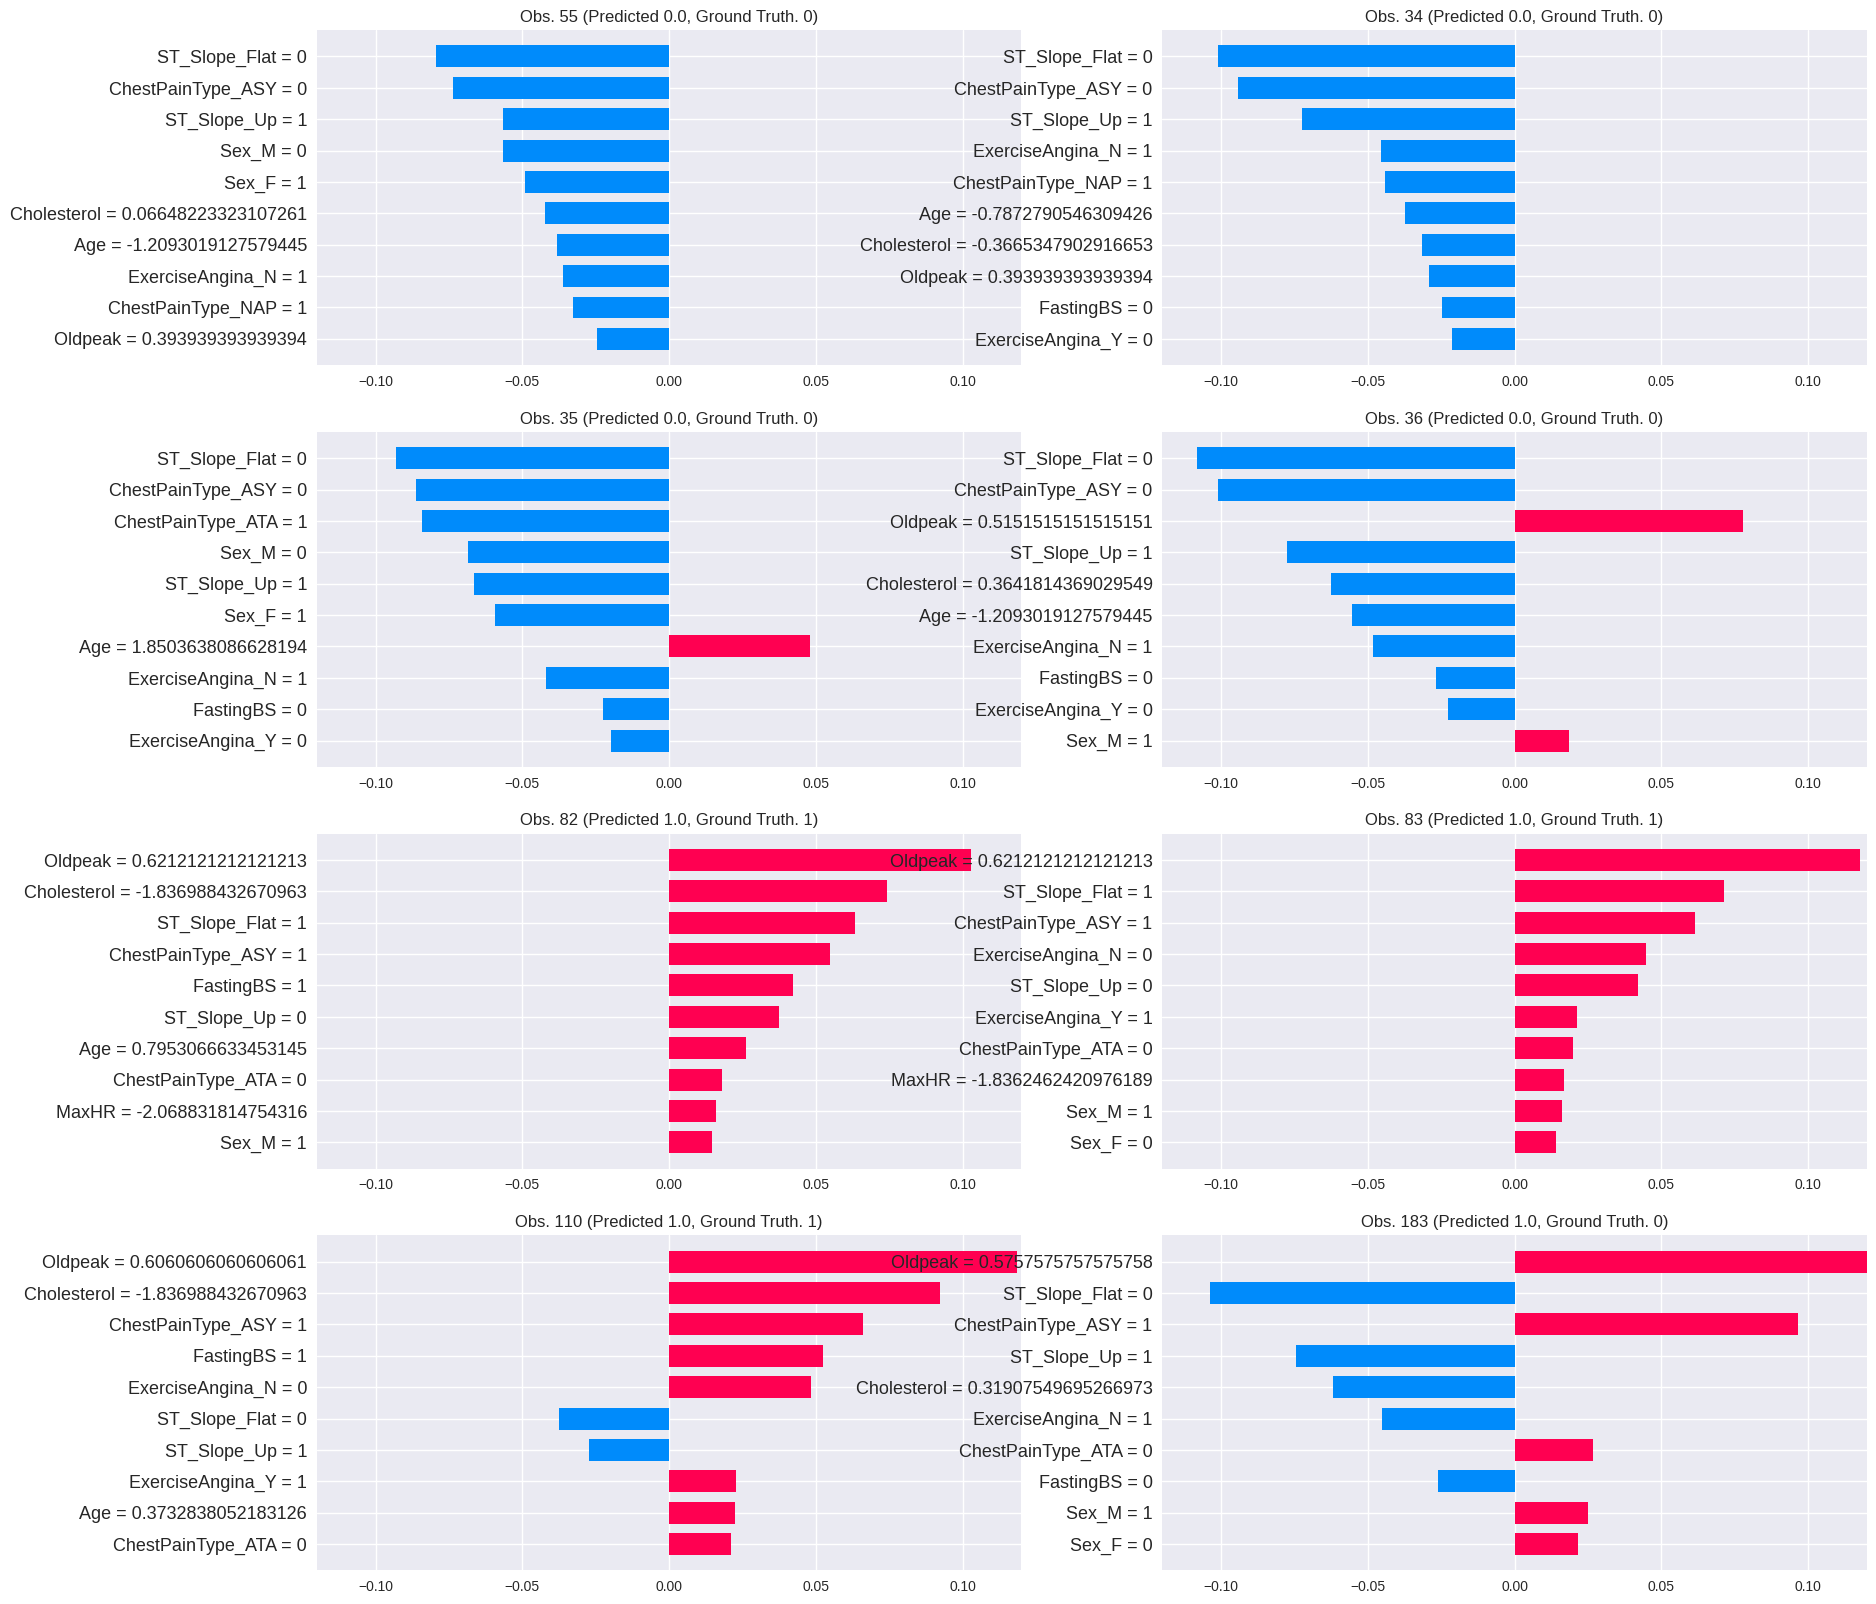

In [58]:
# Using Deep Explainer after the discussion with colleagues post multiple failed attempts
explainer = shap.DeepExplainer(model, x_tr)
shap_values = explainer.shap_values(torch.tensor(x_test.values, dtype=torch.float))
col_names = x_train.columns

# Define custom color palette
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

pos_obs = np.argsort(y_pred_test[:,0])[:4]
neg_obs = np.argsort(y_pred_test[:,0])[-4:]
ind = np.concatenate((pos_obs, neg_obs))

plt.figure(figsize=(20, 20))
for i, obs in enumerate(ind):
    ax = plt.subplot(4, 2, i+1)
    ax.set_title("Obs. " + str(obs) + " (Predicted " + str(np.round(y_pred_test[obs,0], 2)) + ", Ground Truth. " + str(y_test[obs]) + ")")
    shap.bar_plot(shap_values[obs], x_test.values[obs], feature_names = col_names, show=False, max_display=10)
    plt.xlabel("")
    plt.xlim(-0.12, 0.12)

In [67]:
print(model)

Model(
  (features): Sequential(
    (0): BlockLinear()
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BlockLinear()
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): BlockLinear()
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): BlockLinear()
  )
  (lr): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
